#Image Classification Efficientnet


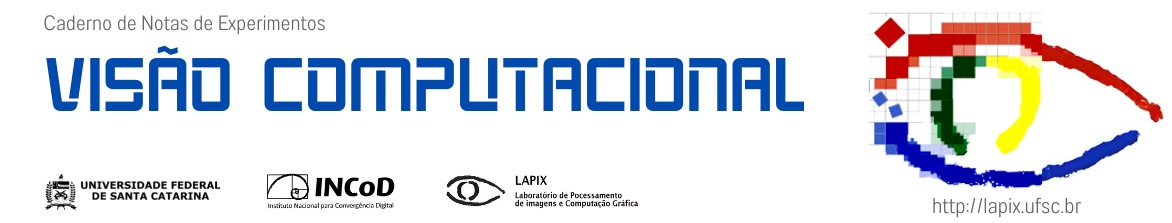

# Autores:


* Aldo Von Wangenheim: aldo.vw@ufsc.br
* Thiago Zimmermann Loureiro Chaves: thiago.zlc@grad.ufsc.br





# Para utilizar a placa de vídeo no Google Colab...

1) clique no ▾ do lado de "Conectar"

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

5) Execute a célula abaixo. Ela deve retornar as informações da placa de vídeo.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Fri Jun 30 18:03:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install fastai torch torchvision
!pip install wandb -qU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from fastai.vision.all import *
from torchvision.models import *
from fastai.callback.wandb import *

import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os

# Codigo para montar o Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/Shareddrives/MindFunga/SplittedProtax28-03/"

config.yml  Esporos1000x  Himenio1000x	Poros100x  Poros35x


In [ ]:
# Set up data directory
path = Path("/content/gdrive/Shareddrives/MindFunga/SplittedProtax28-03/Poros35x")
train_path = path/'train'
valid_path = path/'val'
test_path = path/'test'
size = 512
batch_size = 8

In [ ]:
data = ImageDataLoaders.from_folder(
    path, train='train', valid='val', test='test',
    item_tfms=Resize(size),
    batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)],
    bs=batch_size,
    num_workers=0
)


#Selecionamos a Rede Neural


*   EfficientnetB0
*   EfficientnetB1
*   EfficientnetB2
*   EfficientnetB3
*   EfficientnetB4
*   EfficientnetB5
*   EfficientnetB6
*   EfficientnetB7

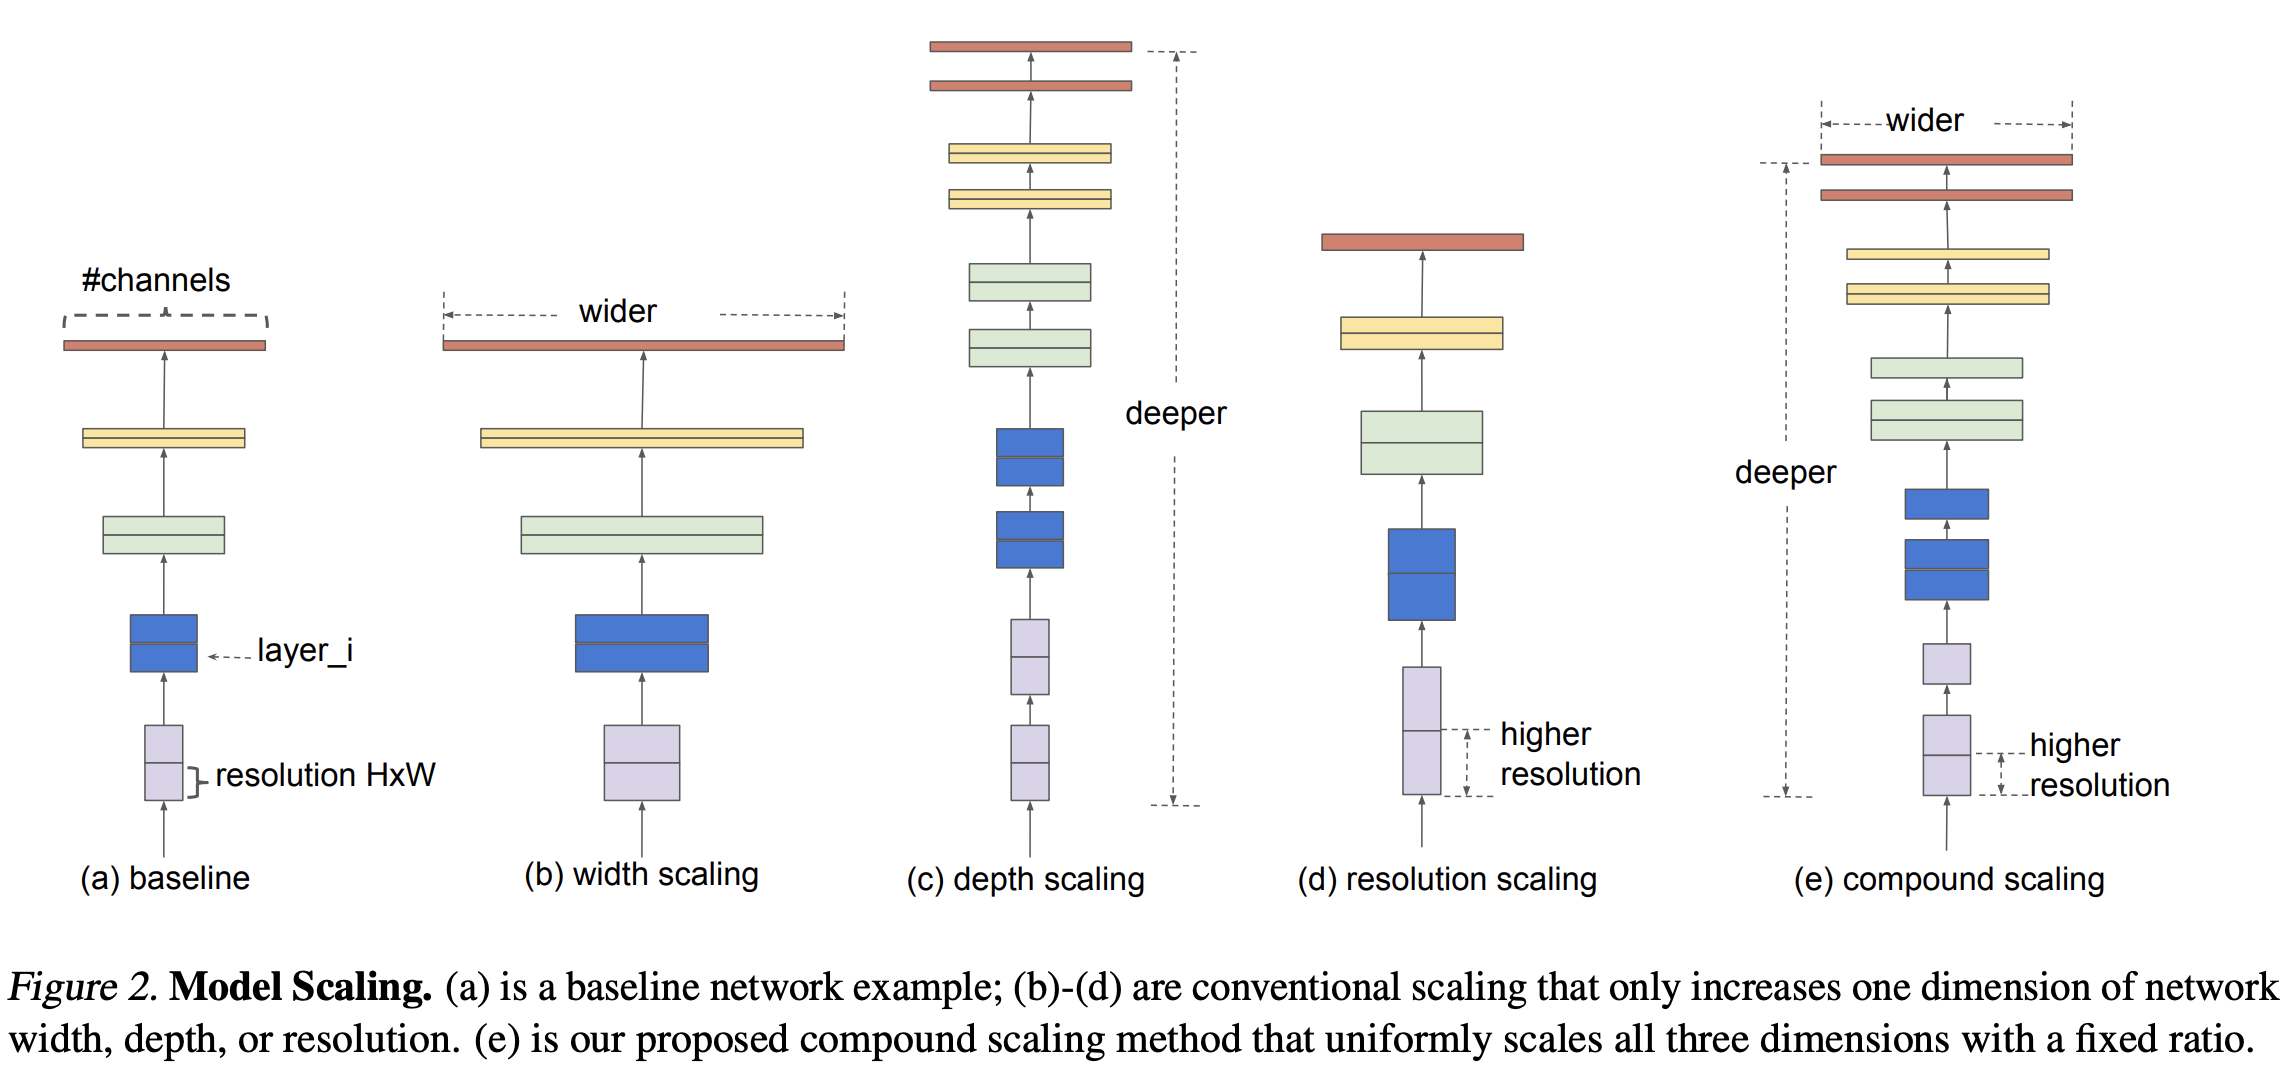



In [ ]:
from fastai.vision.models import efficientnet_b0
arch = efficientnet_b1(weights=True)
model = nn.Sequential(arch, nn.Linear(in_features=1000, out_features=data.c, bias=True))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#Definimos o Learner

In [ ]:
# Define learner
learn = Learner(
    dls=data,
    model=arch,
    metrics=[accuracy, top_k_accuracy],
    opt_func=Adam,
    loss_func=LabelSmoothingCrossEntropy(),
    cbs=[WandbCallback()]
)

In [ ]:
# Train model
wandb.init(project="Tcc_Poros35x_Abril_3classes", config={
    "learning_rate": 1e-3,
    "epochs": 15,
    "batch_size": batch_size
})

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-3)

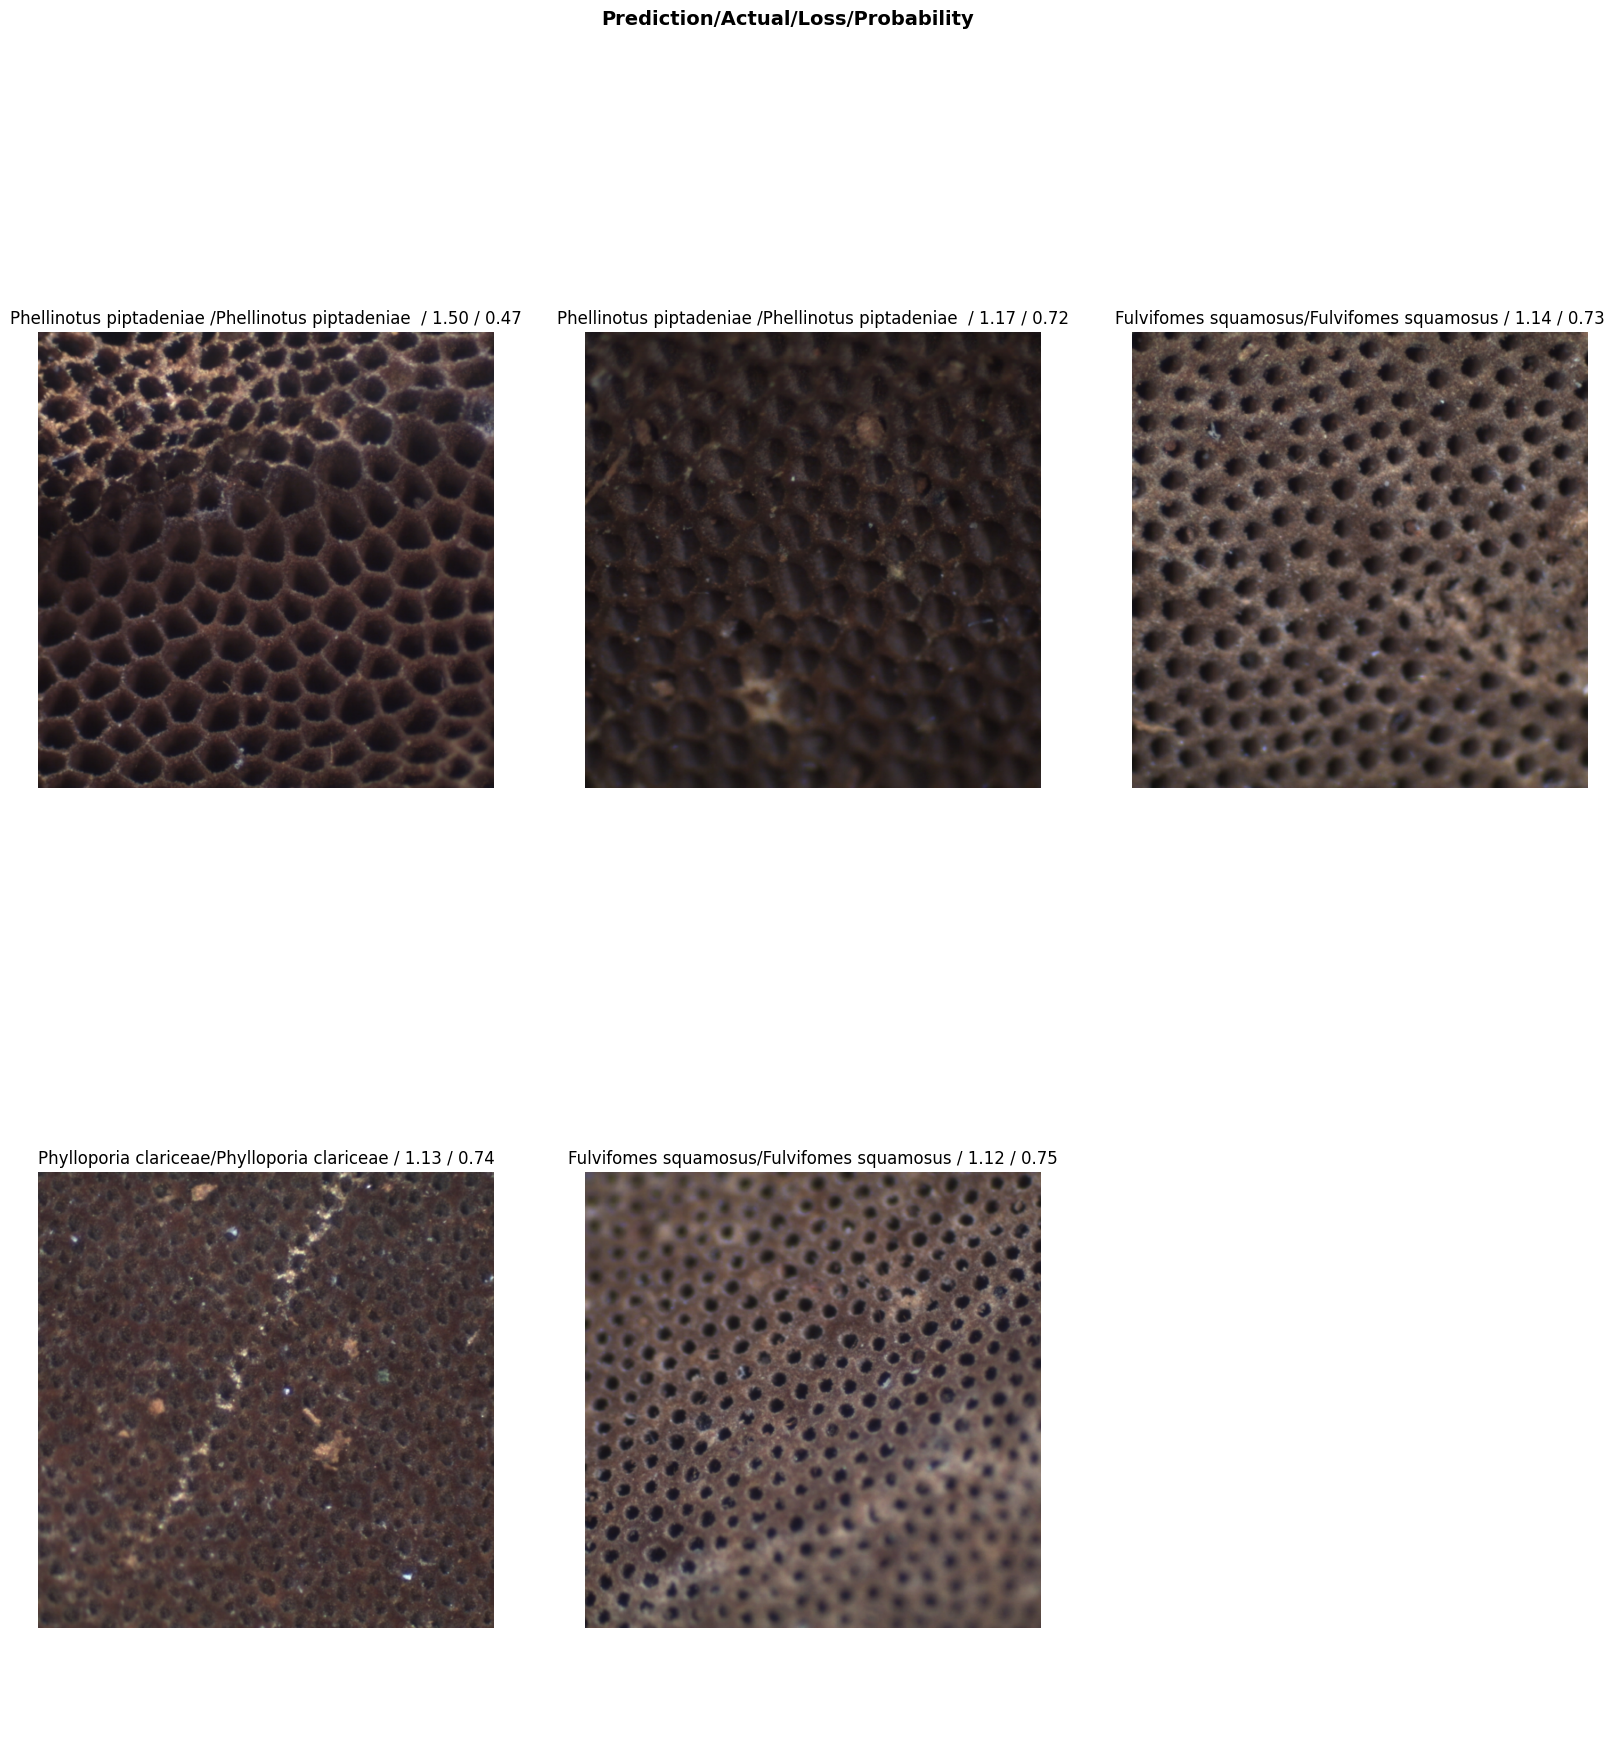

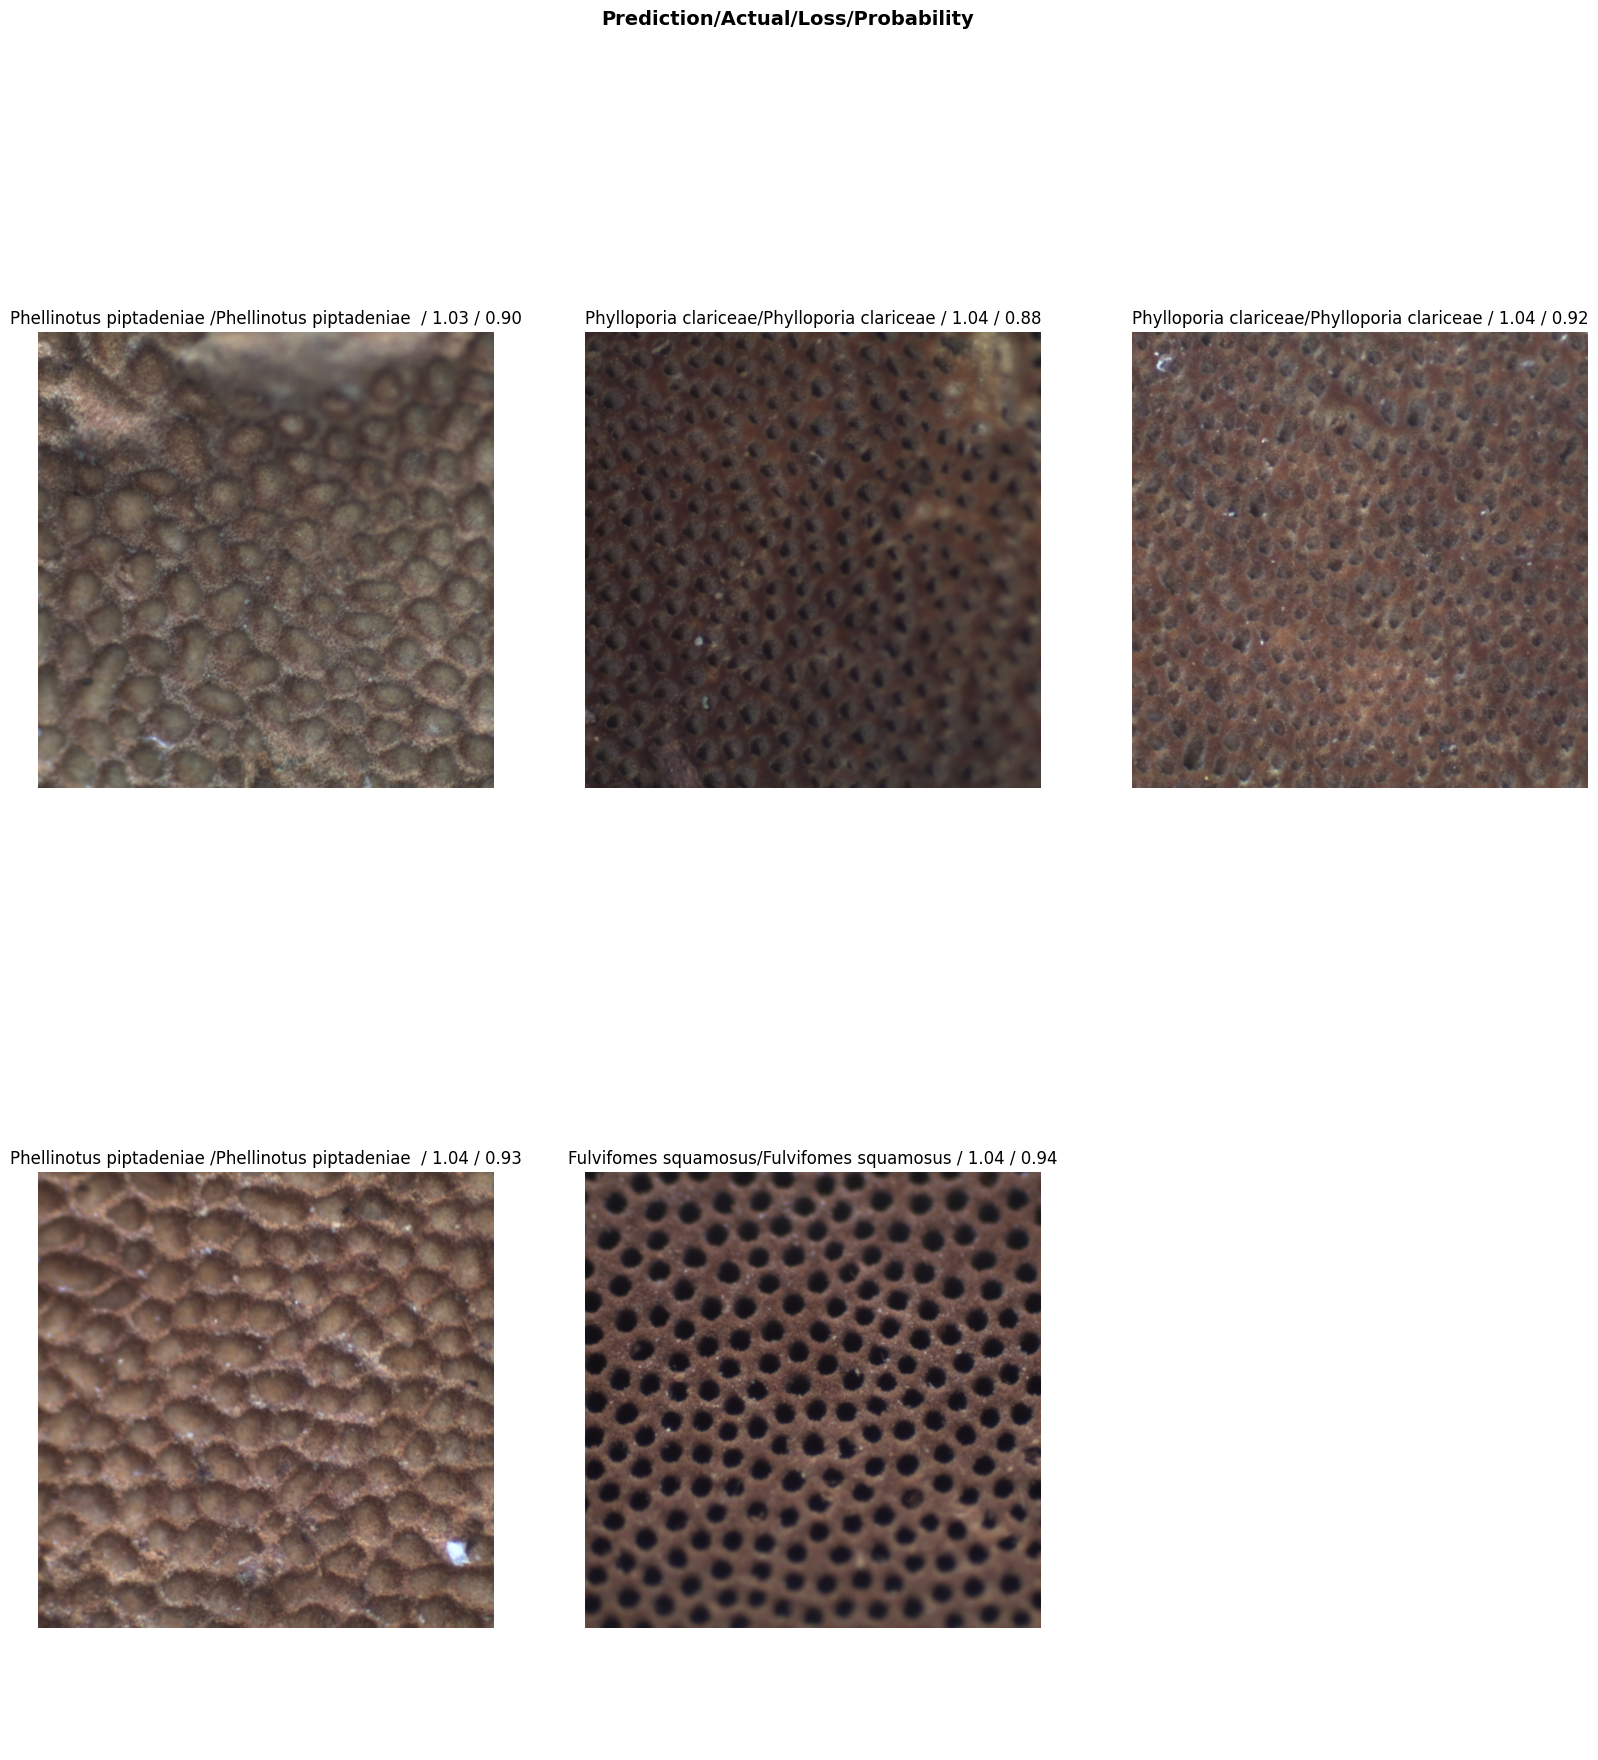

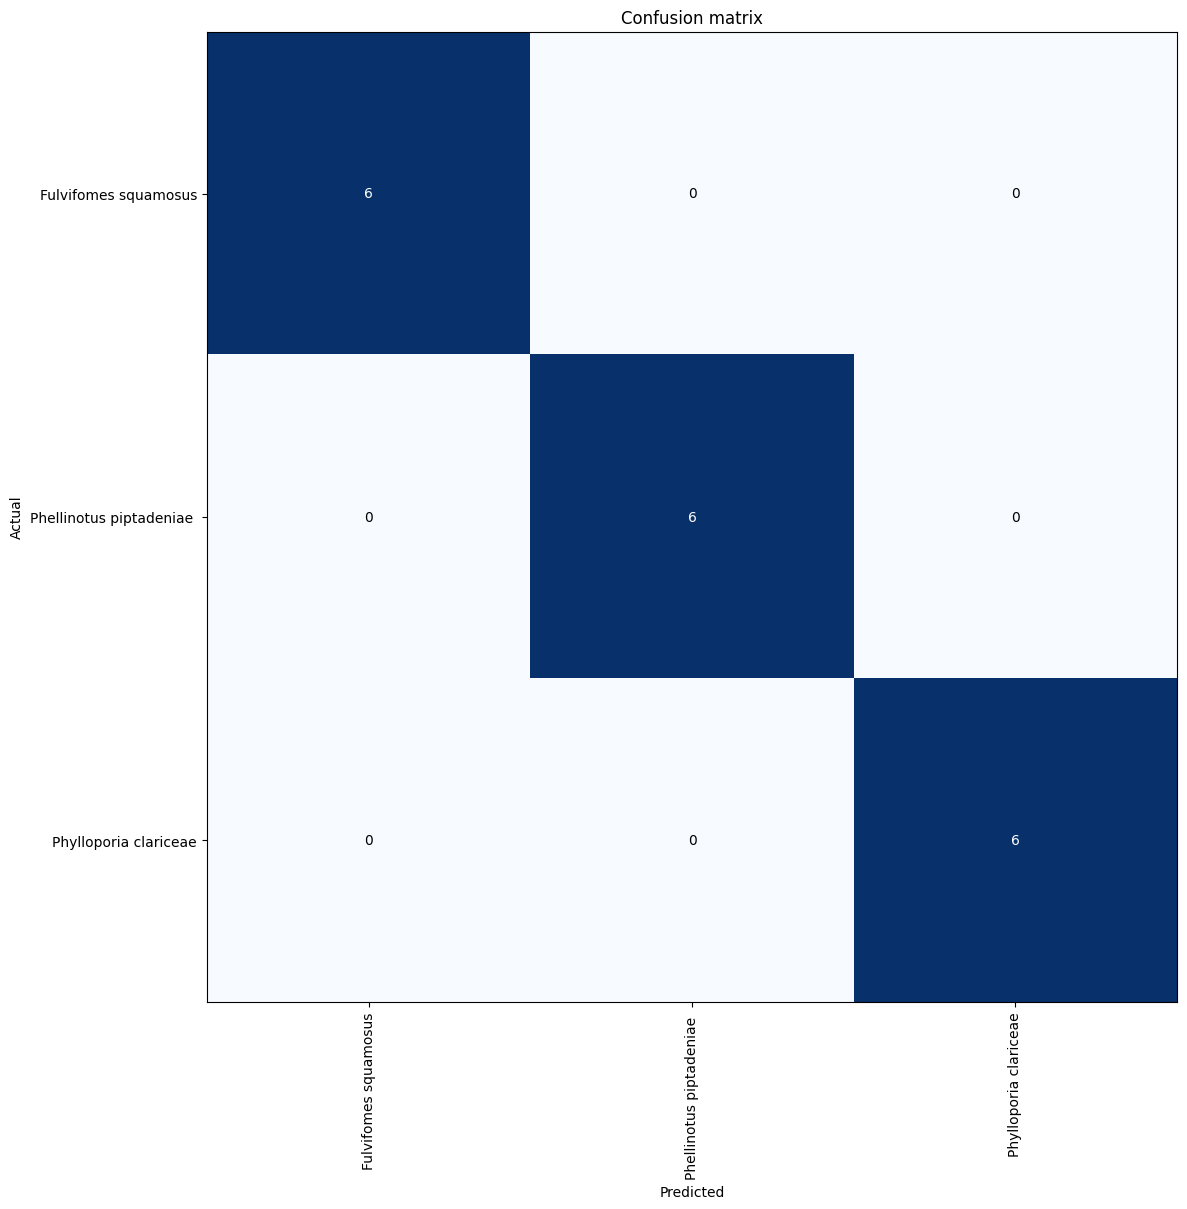

In [ ]:
# Evaluate model on validation set
interp = ClassificationInterpretation.from_learner(learn)

# Display best 5 and worst 5 results
interp.plot_top_losses(5, figsize=(20,20))
interp.plot_top_losses(5, largest=False, figsize=(20,20))

# Display heatmap of accuracy for each class
interp.plot_confusion_matrix(figsize=(12, 12), cmap='Blues')